In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from como.mococomo import MoreComponentCoMo
from como.mococomo import pi_tilde2pi_vec

import numpy as np
import jax
import jax.numpy as jnp

In [5]:
def sim_ser(p, sigma0=1.0):
    beta = np.zeros(p)
    idx = np.random.choice(p)
    beta[idx] = np.random.normal() * sigma0
    return beta

def sim_susie(p, sigma0=1.0, L=5):
    beta = sum([sim_ser(p, sigma0) for _ in range(L)])
    return beta

def sim_mococomo(n, p, sigma0, L, K):
    # covariates
    X = np.random.normal(size=(n, p))
    Z = np.ones(n)[:, None]

    # effect distribution
    scales = np.cumprod(np.ones(K) * np.sqrt(2))
    B = np.array([sim_susie(p, sigma0, L) for _ in range(K-1)])
    Xb = X @ B.T
    pi_tilde = jax.nn.sigmoid(Xb)
    pi = np.array(pi_tilde2pi_vec(pi_tilde))

    # latent variables
    z = np.array([np.random.choice(K, 1, p=p) for p in pi]).squeeze()
    beta = np.random.normal(size=n) * scales[z]

    # observed data
    se = np.random.gamma(2., size=n)
    beta_hat = beta + np.random.normal(size= n) * se

    sim = dict(
        X = X,
        Z = Z,
        B = B,
        pi = pi,
        z = z,
        beta=beta,
        se = se,
        beta_hat = beta_hat,
        scales=scales
    )
    return sim


n = 1000
p = 20
L = 2
sigma0 = 5.
K = 5

sim = sim_mococomo(n, p, sigma0, L, K)

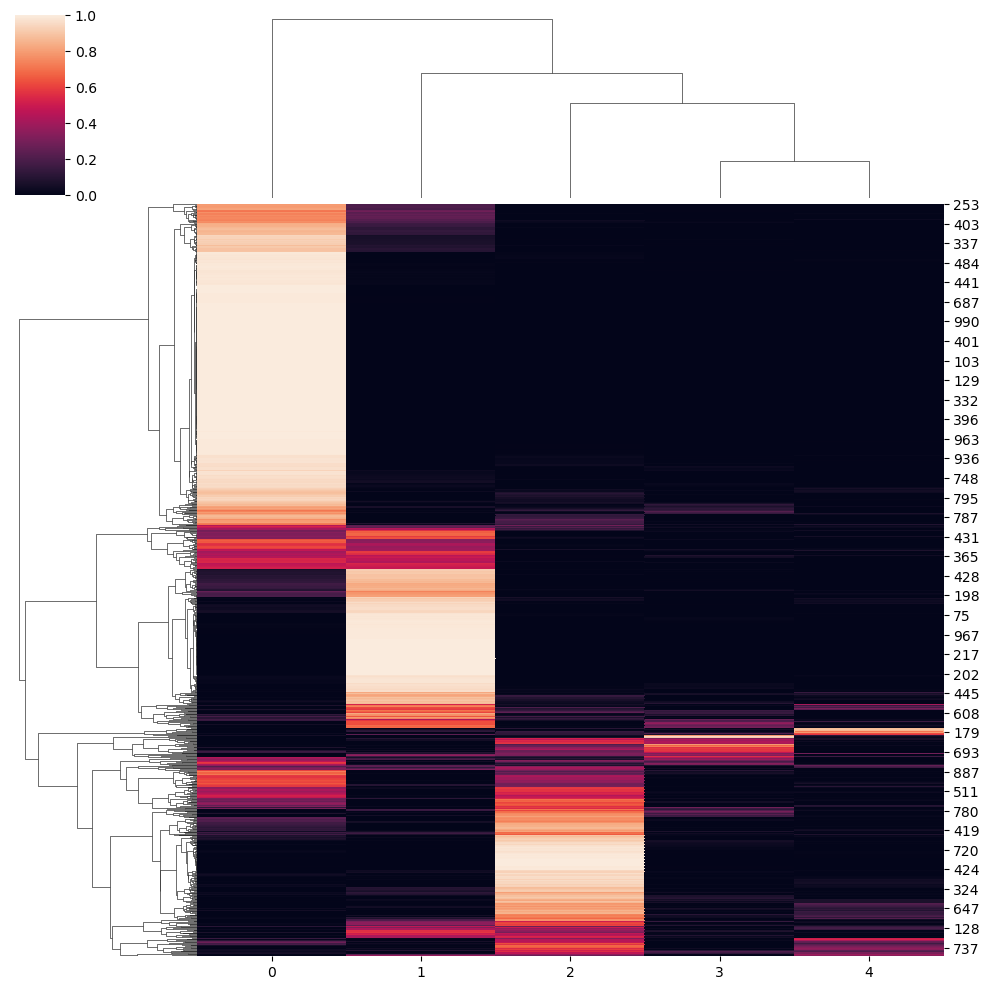

Observations per component: [488 255 205  31  21]


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.clustermap(sim['pi']); plt.show(); plt.close();
print(f"Observations per component: {np.bincount(sim['z'])}")

In [7]:
from como.component_distributions import NormalFixedLocComponent
from como.logistic_regression import LogisticSusie
import numpy as np
from como.mococomo import mococomo_compute_responsibilities

scales = sim['scales']
f_list = [NormalFixedLocComponent(0., scale=scale) for scale in scales]
[f.freeze() for f in f_list];

In [8]:
data = dict(
    beta = sim['beta_hat'],
    se = sim['se'],
    X = sim['X'],
    Z = sim['Z']
)

data['y'] = sim['z'] == 0
data['n'] = 1.

# random initialization of the binomial regression "data"
Y = np.ones((n, K)) / K
N = 1 - (jnp.cumsum(Y, 1) - Y)
data['Y'] = Y
data['N'] = N

In [9]:
# each of the K-1 logistic regressions gets it's own index
logreg_list = [LogisticSusie(data, L=5, idx=idx)
    for idx in range(K-1)]
[logreg_list[i].hypers['idx'] for i in range(K-1)]

elbos = []

[0, 1, 2, 3]

In [33]:
from como.mococomo import mococomo_compute_responsibilities, mococomo_elbo

def update_responsibilities():
    Y = mococomo_compute_responsibilities(
        data, f_list, logreg_list)
    N = 1. - (jnp.cumsum(Y, 1) - Y)
    data['Y'] = Y   
    data['N'] = N

def update_logreg():
    [f.update() for f in logreg_list]

update_logreg()
update_responsibilities()

mococomo_elbo(data, f_list, logreg_list, data['Y'])['total_elbo']

DeviceArray(-11231.404, dtype=float32)

In [18]:
from como.mococomo import *

data_loglik = mococomo_loglik(
    data, f_list, data['Y'], sum = False)
assignment_entropy = categorical_entropy_vec(data['Y'])

logreg_elbo = sum([ll.evidence() for ll in logreg_list])
total_elbo = jnp.sum(data_loglik + assignment_entropy) + logreg_elbo


In [17]:
sum([ll.evidence() for ll in logreg_list])

DeviceArray(384.89066, dtype=float32)

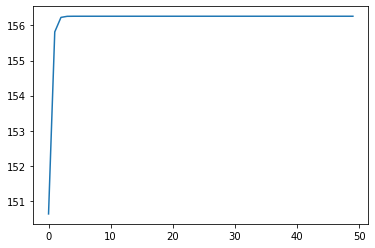

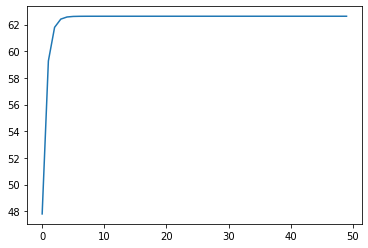

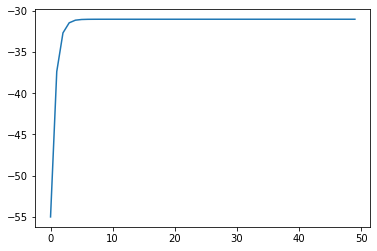

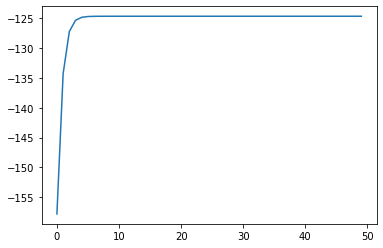

In [216]:
elbos = {i: [] for i in range(4)}

for idx, model in enumerate(logreg_list):
    for _ in range(50):
        model.update()
        elbos[idx].append(model.evidence())


for idx in elbos:
    plt.plot(elbos[idx])
    plt.show()
    plt.close()

In [217]:
fit = LogisticSusie(data, L=5, idx=0)
print(fit.evidence())
fit.update()
print(fit.evidence())


-544.7101
150.63058


In [9]:
from como.logistic_susie import Xb2_susie
from como.logistic_ser import _compute_tau
from como.utils import polya_gamma_mean

params, hypers = init_susie(data, idx=0)
# update_xi_susie(datNonea, params, hypers)
Xb2 = Xb2_susie(data, params)
xi = jnp.sqrt(jnp.abs(Xb2))
N = _get_N(data, hypers)
omega = polya_gamma_mean(N, xi)
tau = omega @ (data['X']**2)
# tau = _compute_tau(data, hypers, xi)


In [10]:
data['Y'][:, 4] = data['y']
data['N'] = np.ones((n, K-1))

In [11]:
params.keys()
params['tau'].shape

(20,)

In [111]:
from como.logistic_susie import susie_iter

fit = LogisticSusie(data, L=10, idx=3)
fit.evidence()
fit.update()

In [118]:
fit.update()
fit.evidence()

DeviceArray(119.785355, dtype=float32)

In [109]:
parmas, hypers = fit.params, fit.hypers
params, hypers = susie_iter(data, params, hypers)

fit.params = params
fit.hypers = hypers
fit.evidence()


DeviceArray(nan, dtype=float32)

In [108]:
parmas, hypers = fit.params, fit.hypers
params, hypers = susie_iter(data, params, hypers)

fit.params = params
fit.hypers = hypers
fit.evidence()

DeviceArray(nan, dtype=float32)

In [119]:
elbos = []
for i in range(20):
    fit.update()
    elbos.append(fit.evidence())
elbos = np.array(elbos)
plt.plot(elbos)

IndexError: tuple index out of range

In [109]:
np.array(elbos)

array([334.25714, 334.2571 , 334.25714, 334.25702, 334.2569 , 334.2569 ,
       334.25696, 334.25702, 334.257  , 334.257  , 334.25702, 334.25705,
       334.25696, 334.25708, 334.25705, 334.25684, 334.2571 , 334.25708,
       334.25708, 334.25705], dtype=float32)

In [10]:
from como.component_distributions import NormalScaleMixtureComponent, lossNSM, gradNSM, hessNSM, newtonNSM
from como.component_distributions import _nsm_convolved_logpdf, eta2pi, pi2eta
import numpy as np
import jax.numpy as jnp
from jax import jit
import jax
import matplotlib.pyplot as plt

n = 100000
scales = np.array([1.0, 2.0, 4.0, 8.0, 16.0, 32.0])
eta = np.random.normal(size = scales.size-1)
pi = np.array(eta2pi(eta))

z = np.random.choice(6, replace=True, size=n, p=pi/pi.sum())
beta = np.random.normal(size=n) * scales[z]
se = np.ones(n)
beta_hat = beta + np.random.normal(size=n) * se